# WeatherPy Analysis

## Question 
The fundamental question that we are trying to answer in this exercise is:
"What's the weather like as we approach the equator?"

## Objective
To visualize the weather of 500+ randomly selected cities across the world of varying distance from the equator. To build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

## Technical Considerations
* Use python's library - [random](https://docs.python.org/3/library/random.html#), to generate the random city coordinates to be used. This will ensure that the coordinates are in fact not manually picked, but generated randomly
* Use a python library - [citipy](https://pypi.python.org/pypi/citipy), to get our list of cities from the randomly generated coordinates. This library will give us the nearest city for a given set of coordinates.
* Use the [OpenWeatherMap API](https://openweathermap.org/api) to get the weather data for all the cities that we get from our random coordinates
* Use Matplotlib libraries for Data Visualization

## Observations
From the plots in our analysis we see the following:
* Temperatures are higher on an average in the Southern Hemisphere and are lower in the Northern Hemisphere especially as we move away from the equator. Most cities in the southern hemisphere have temperatures above 50 deg F. Cities in the top 2/3rd of the Northern Hemisphere have temperatures in the range of -10 to 50 deg F.
* Cities near the equator have much higher temperatures than those away from the equator.
* There are a lot more cities with humidity in the 60% to 100% range around the globe. There are more cities in the southern hemisphere with higher humidity levels (80-100%).
* Most cities have wind speeds in the 0 to 20 mph range with more than half in the 0-10mph range.
* Cloudiness in cities is evenly distributed around the globe.

## Conclusion
Cities closer to the equator are hotter than cities away from the equator with more cities in the south of the equator being warmer. Proximity to the equator does not affect other factors like Humidity, Cloudiness or Wind Speed as much as it affects the Temperature

## Analysis Process
### Setting up the list of random cities around the globe
We use the citipy library to generate 150 random positive latitude numbers, negative latitude numbers, positive longitude numbers and negative longitude numbers. This will ensure that we have coordinate samples from all four quadrants of the globe. Furthermore we get random latitudes from two sections 0 to 45 and 45 to 90 in both hemispheres to ensure even distribution of latitudes close to and away from the equator. We generate more than 500 cities because we may not get weather data for some of them later.

In [1]:
# Import Dependencies
from citipy import citipy
import requests as req
import json
import pandas as pd
import numpy as np
import re, json, progressbar, yaml
from datetime import datetime
from time import sleep
import logging
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load all the keys and other configuration from the config file
with open("../config.yaml") as y:
    config = yaml.load(y)
print(config)

{'author': {'name': 'Rupali Mayekar'}, 'projects': {'weatherpydashboard': {'num_cities': 600}}, 'keys': {'weathermapapi': {'api_key': '7e4ae0373bdeed043f36aeafca9fc7ff'}, 'mapbox': {'access_token': 'pk.eyJ1IjoicnVwYWxpbWF5ZWthciIsImEiOiJjamZvanN3d2owM3lpMndwOXh1cGRvbHV0In0.YRNJn4K6zkxPv_kORZ_TVg'}}}


In [3]:
# Setting up the logging template by adding some extra keys so we can pass them into the message
template = '%(asctime)s %(message)s %(wid)s %(city_name)s %(weather_url)s '
logging.basicConfig(filename="./output/weather.log", filemode='w', format=template)

In [4]:
NUM_CITY = config["projects"]["weatherpydashboard"]["num_cities"]

lats = np.random.uniform(-90, 90, NUM_CITY)
lons = np.random.uniform(-180, 180, NUM_CITY)

In [5]:
coords = []
for i in range(len(lats)):
    coords.append((lats[i], lons[i]))   

In [6]:
# Use the citipy library to get the nearest city for each of the set of coordinates generated above. 
# This should give us a list of 600 random cities along with their country codes
cities = [citipy.nearest_city(coord[0], coord[1]) for coord in coords]

In [7]:
# Create a city table with the city names and country codes that we have gathered above. We will add the 
# other weather information for these cities later
cities_df = pd.DataFrame(data = {"City Name": [city.city_name for city in cities],
                                "Country Code": [ city.country_code for city in cities]})

In [8]:
# Add columns for the remaining data for all the cities that we will collect
cities_df = pd.concat([cities_df,pd.DataFrame(columns=["City ID", "Latitude", "Longitude", "Temperature", "Pressure", "Humidity", "Cloudiness", "Wind Speed"])])

# Reorder the columns
cities_df = cities_df[["City ID", "City Name", "Country Code", "Latitude", "Longitude", "Temperature", "Pressure", "Humidity", "Cloudiness", "Wind Speed"]]

### A sneak peak at the data table with the cities and country codes populated.

In [9]:
cities_df.head()

,City ID,City Name,Country Code,Latitude,Longitude,Temperature,Pressure,Humidity,Cloudiness,Wind Speed
0,NaN,maumere,id,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,gorodishche,ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,westport,nz,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,mehamn,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,cape town,za,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(cities_df)

600

In [11]:
# drop any duplicate cities if any
cities_df.drop_duplicates()
len(cities_df)

600

### Getting the weather data
We now loop through all the cities in our data frame and make an api call to the OpenWeatherMap Api. The Api Key we have allows for no more than 60 calls per minute. So after every 60 calls we pause for a  minute before moving to the next batch of 60 calls. If we get an error for any missing data for a city, we simply skip that city.

In [12]:
def get_weather_data(city_name="Santa Fe", country_code="US"):
    BASE_URL = "https://api.openweathermap.org/data/2.5/weather/"
    API_KEY = config["keys"]["weathermapapi"]["api_key"]
    
    params = {
        "q": "{},{}".format(city_name, country_code),
        "APPID": API_KEY,
        "units": "imperial"
    } 
    r = req.get(BASE_URL, params = params)
    return r, r.json()

In [13]:

cities = {}

for index,row in cities_df.iterrows():
    key = "{},{}".format(row["City Name"], row["Country Code"])


    city_log = {"wid": "",
            "city_name": key,
            "weather_url": "" }

    try:
        resp, weather = get_weather_data(row["City Name"], row["Country Code"]); 
        sleep(1);
    except Exception as e:
        logging.critical("ERROR GETTING WEATHER DATA: {0}".format(e), extra = city_log)
        break

    if weather.get("name"):
        
        cities[key] = weather
        city_log["wid"] = weather["id"]
        city_log["weather_url"] = resp.url
        
        # make warning log
        logging.warning("City Found: ", extra = city_log)
        
        row["City ID"] = weather["id"]
        row["Latitude"] = weather["coord"]["lat"]
        row["Longitude"] = weather["coord"]["lon"]
        row["Temperature"] = weather["main"]["temp"]
        row["Pressure"] = weather["main"]["pressure"]
        row["Humidity"] = weather["main"]["humidity"]
        row["Cloudiness"] = weather["clouds"]["all"]
        row["Wind Speed"] = weather["wind"]["speed"]

    else:
        # make critical log
        logging.critical("WE HAVE A PROBLEM WITH THE WEATHER DATA", extra = city_log)

In [14]:
with open ('./output/weather_data.json', 'w') as fp:
    json.dump(cities, fp)

### Data cleanup and a sneak peak at our final data
We now remove any rows that do not have some weather data. We also convert all the numeric columns to float for the visualizations

In [15]:
cities_df.head()


,City ID,City Name,Country Code,Latitude,Longitude,Temperature,Pressure,Humidity,Cloudiness,Wind Speed
0,1635815,maumere,id,-8.63,122.22,81.41,1013.12,100,56,3.71
1,559643,gorodishche,ru,53.27,45.7,41.36,1002.5,87,0,7.74
2,2206900,westport,nz,-41.75,171.6,42.26,982.07,92,0,6.4
3,778707,mehamn,no,71.03,27.85,30.38,1010.69,93,88,9.42
4,3369157,cape town,za,-33.93,18.42,63.68,1028.92,84,0,26.08


In [16]:
print("Total number of cities before dropping empty data: " + str(len(cities_df)))

Total number of cities before dropping empty data: 600


In [17]:
# Delete the rows with the cities that have no data
cities_df.dropna(inplace=True)
print("Total number of cities after dropping empty data: " + str(len(cities_df)))

Total number of cities after dropping empty data: 529


In [18]:
# Sneak peak at our data
cities_df.head()

,City ID,City Name,Country Code,Latitude,Longitude,Temperature,Pressure,Humidity,Cloudiness,Wind Speed
0,1635815,maumere,id,-8.63,122.22,81.41,1013.12,100,56,3.71
1,559643,gorodishche,ru,53.27,45.7,41.36,1002.5,87,0,7.74
2,2206900,westport,nz,-41.75,171.6,42.26,982.07,92,0,6.4
3,778707,mehamn,no,71.03,27.85,30.38,1010.69,93,88,9.42
4,3369157,cape town,za,-33.93,18.42,63.68,1028.92,84,0,26.08


In [19]:
# For our visualizations we will convert all the numeric columns to float
cities_df['Latitude'] = cities_df['Latitude'].astype(float)
cities_df['Longitude'] = cities_df['Longitude'].astype(float)
cities_df['Temperature'] = cities_df['Temperature'].astype(float)
cities_df['Pressure'] = cities_df['Pressure'].astype(float)
cities_df['Humidity'] = cities_df['Humidity'].astype(float)
cities_df['Cloudiness'] = cities_df['Cloudiness'].astype(float)
cities_df['Wind Speed'] = cities_df['Wind Speed'].astype(float)

cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 599
Data columns (total 10 columns):
City ID         529 non-null object
City Name       529 non-null object
Country Code    529 non-null object
Latitude        529 non-null float64
Longitude       529 non-null float64
Temperature     529 non-null float64
Pressure        529 non-null float64
Humidity        529 non-null float64
Cloudiness      529 non-null float64
Wind Speed      529 non-null float64
dtypes: float64(7), object(3)
memory usage: 45.5+ KB


In [20]:
# We will save this dataframe into a csv file to be used for the dashboard.
cities_df.to_csv("./output/weather_data.csv")

## Visualizations for the various weather parameters

### City Temperatures around the Globe
Visualization of the temperatures in cities across various latitudes

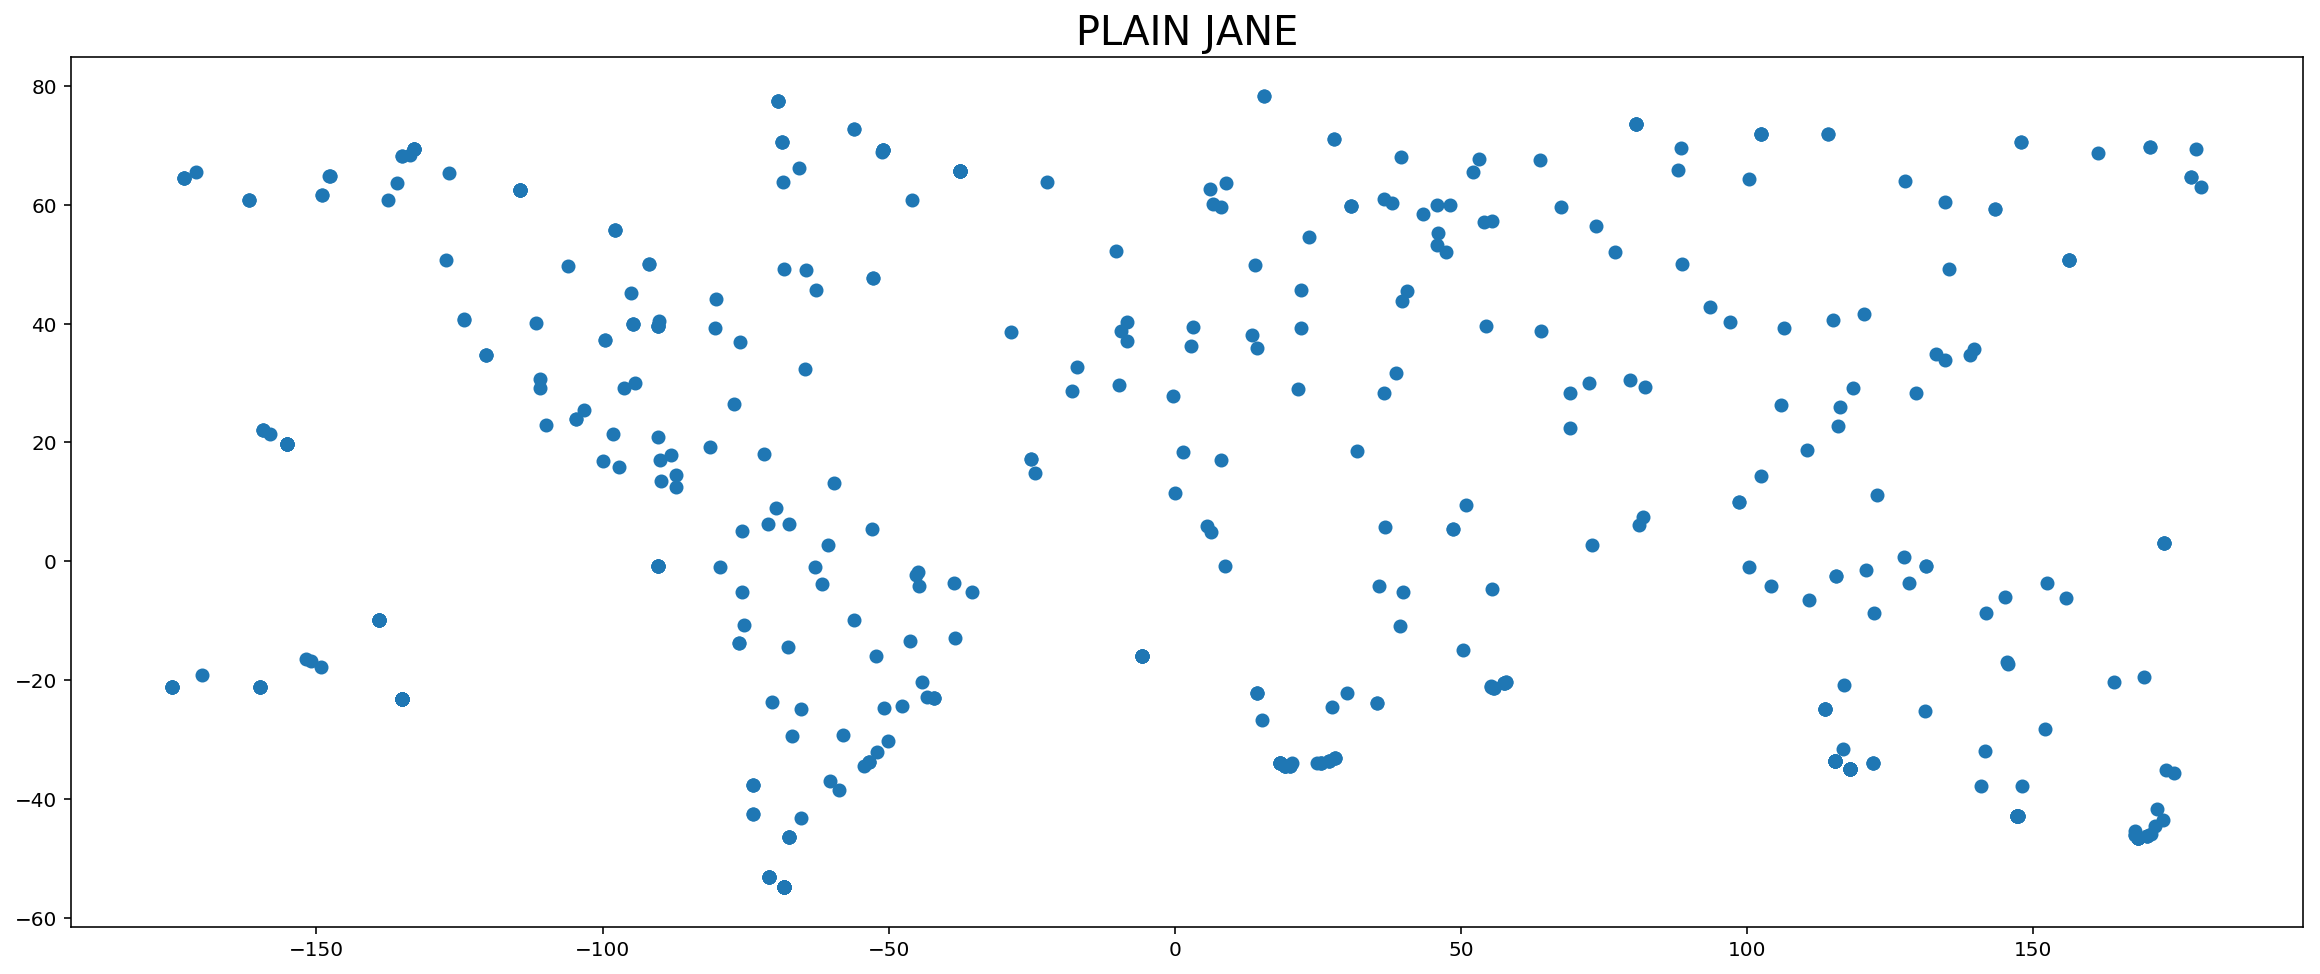

In [21]:
plt.figure(figsize=(20,8))

data = {"x": [], "y": []}
for index, row in cities_df.iterrows():
    data["x"].append(row["Longitude"])
    data["y"].append(row["Latitude"])

plt.title("PLAIN JANE", fontsize=20)
plt.scatter(**data);

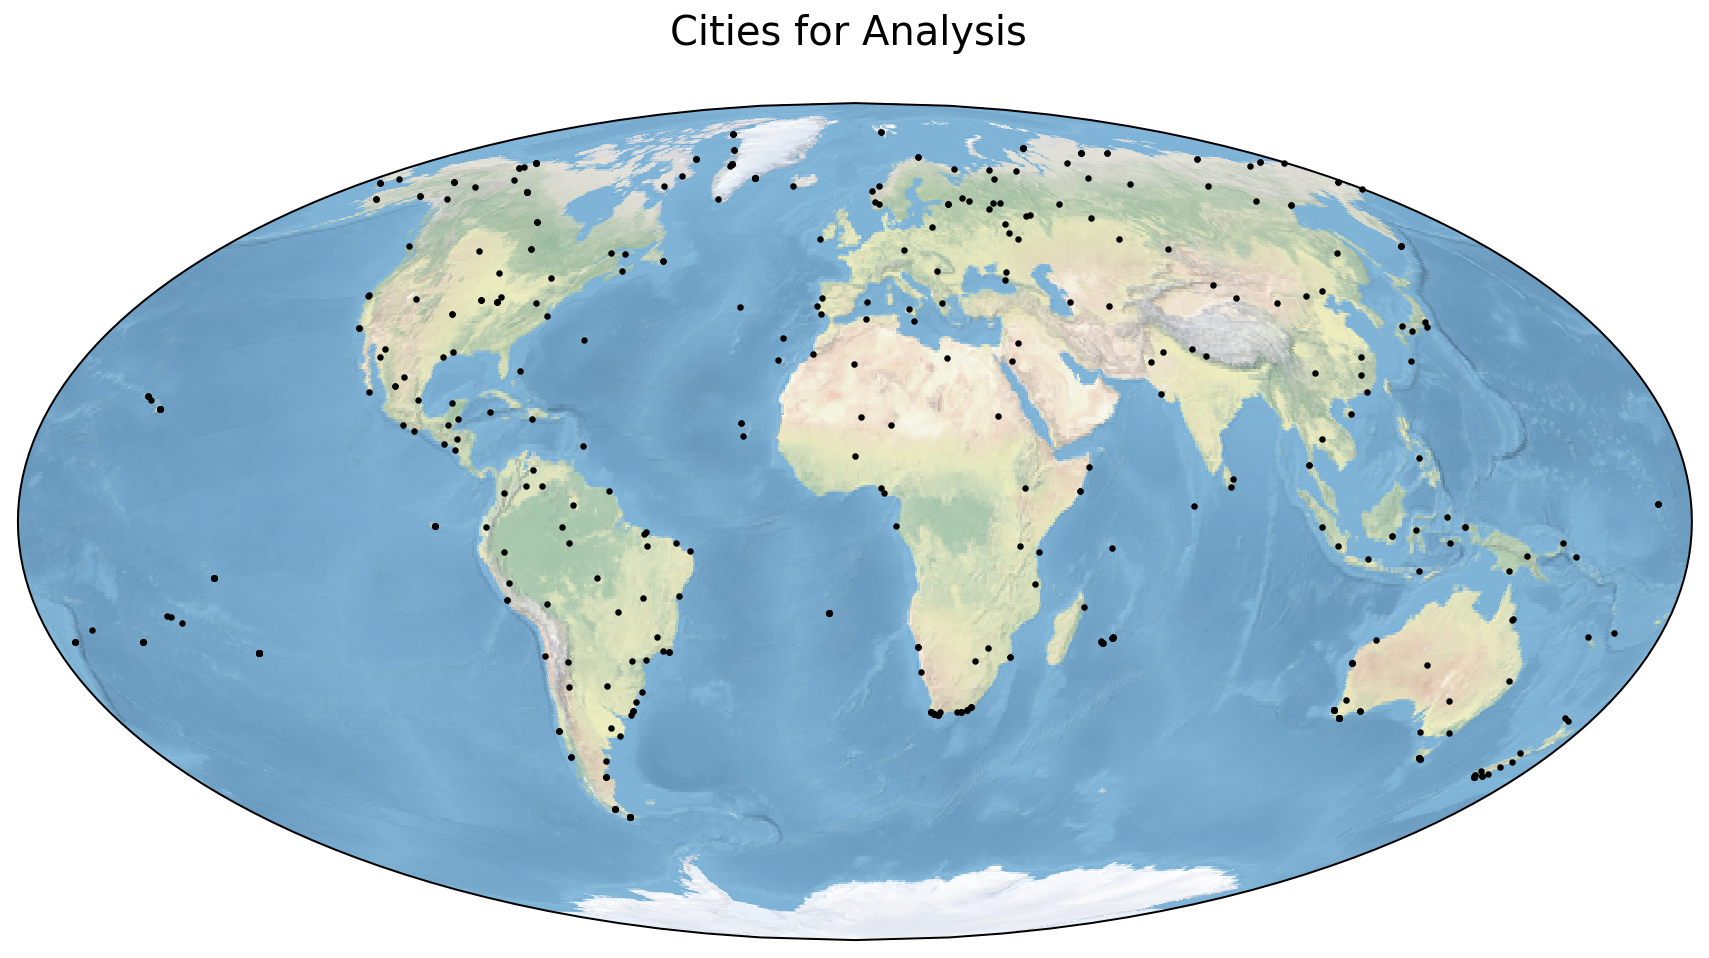

In [22]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
fig.set_size_inches((15, 9))

ax = plt.axes(projection=ccrs.Mollweide(), zorder=2)
# ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
data = {"x": [], "y": []}

for index, row in cities_df.iterrows():
    data["x"].append(row["Longitude"])
    data["y"].append(row["Latitude"])
    
ax.set_title("Cities for Analysis \n", fontsize=20)
ax.scatter(**data, color="black", transform=ccrs.PlateCarree(), s=5);
plt.savefig("./images/cities.png")

In [23]:
# uncomment the line below to see the available colormaps
# plt.colormaps()

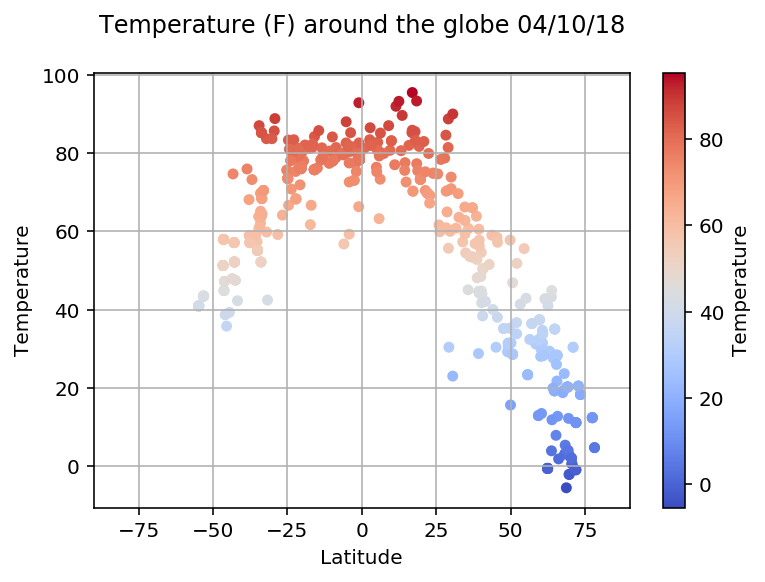

In [24]:
# Setting sharex=False because if not done, the x-axis ticks are not displayed because
# of a bug in the pandas dataframe plot : https://github.com/pandas-dev/pandas/issues/10611
cities_df.plot(kind='scatter', x='Latitude',
                y='Temperature',  
                title="Temperature (F) around the globe {}\n".format(datetime.today().strftime("%m/%d/%y")), 
                c='Temperature', 
                cmap="coolwarm",
                grid=True, xlim=(-90,90), sharex=False)
plt.savefig("./images/temperature.png")

### City Humidity levels around the Globe
Visualization of the humidity levels in cities across various latitudes

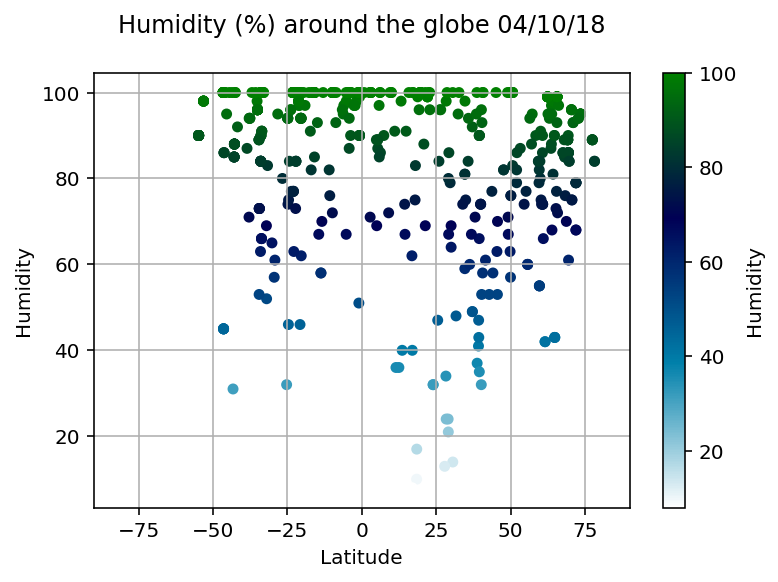

In [26]:
cities_df.plot(kind='scatter', x='Latitude', y='Humidity', 
                title="Humidity (%) around the globe {}\n".format(datetime.today().strftime("%m/%d/%y")), 
                grid=True, xlim=(-90,90),
                c='Humidity', 
                cmap="ocean_r",
                sharex=False)
plt.savefig("./images/humidity.png")

### Wind Speeds in cities around the Globe
Visualization of the wind speeds in cities across various latitudes

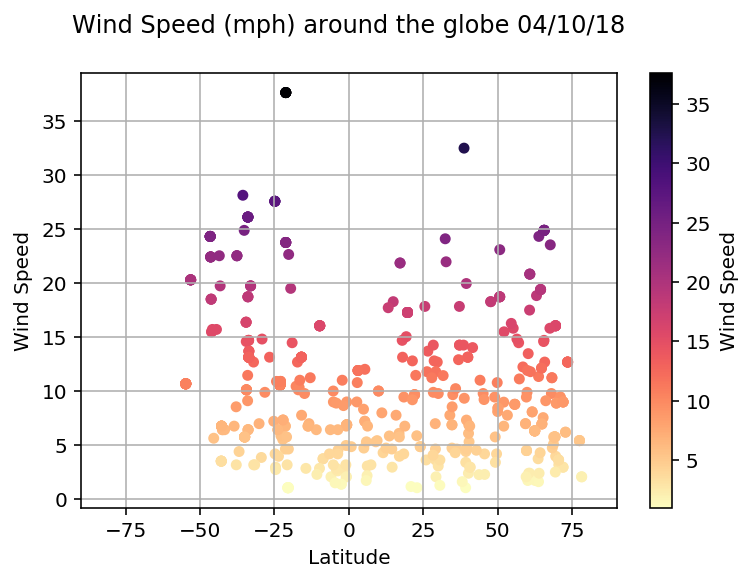

In [27]:
cities_df.plot(kind='scatter', x='Latitude', y='Wind Speed', 
               title="Wind Speed (mph) around the globe {}\n".format(datetime.today().strftime("%m/%d/%y")), 
               grid=True, xlim=(-90,90),
               c="Wind Speed",
               cmap="magma_r",
               sharex=False)
plt.savefig("./images/windspeed.png")

### Cloudiness in cities around the Globe
Visualization of the cloudiness in cities across various latitudes

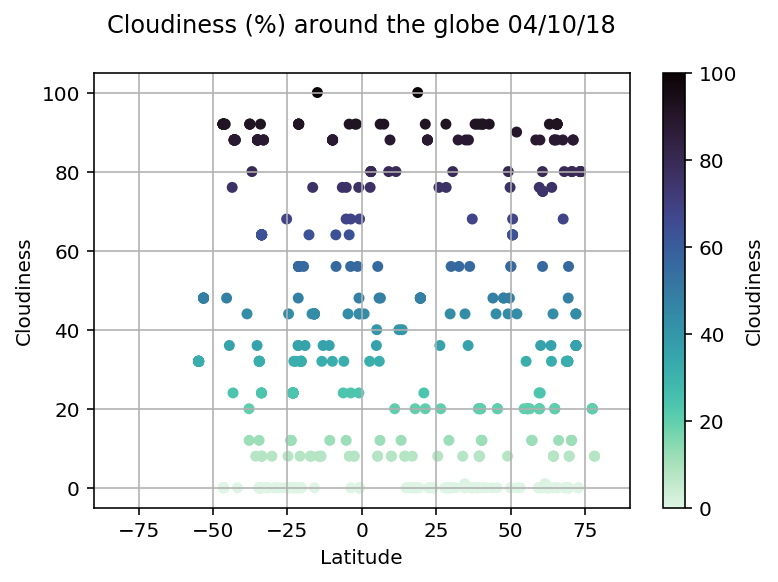

In [28]:
cities_df.plot(kind='scatter', x='Latitude', y='Cloudiness', 
               title="Cloudiness (%) around the globe {}\n".format(datetime.today().strftime("%m/%d/%y")), 
               grid=True, xlim=(-90,90),
               c="Cloudiness",
               cmap="mako_r",
               sharex=False
              )
plt.savefig("./images/cloudiness.png")